In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/02-the-data-toolbox/VADER-the-data-toolbox.csv')

In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,"{'language': 'en', 'score': 0.9999954275035461}",en,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.3612,neg
1,1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,"{'language': 'en', 'score': 0.9999976742625711}",en,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...",0.4927,pos
2,2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,"{'language': 'en', 'score': 0.9999965864363265}",en,"{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp...",0.8126,pos
3,3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,"{'language': 'en', 'score': 0.9999966019854107}",en,"{'neg': 0.035, 'neu': 0.741, 'pos': 0.224, 'co...",0.9133,pos
4,4,2021-03-07,Easy exploratory course,5,completer,23,pos,"{'language': 'en', 'score': 0.9999949623133836}",en,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.4404,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,-0.3612,neg
1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,0.4927,pos
2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,0.8126,pos
3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,0.9133,pos
4,2021-03-07,Easy exploratory course,5,completer,23,pos,0.4404,pos
...,...,...,...,...,...,...,...,...
6032,2016-01-24,This was a great starter for me. I have very l...,5,dropout,160,pos,0.6249,pos
6033,2016-01-24,Useful couple of modules for helping you get s...,4,dropout,145,pos,0.6249,pos
6034,2016-01-24,Very common curse about common data things.,3,dropout,43,neu,-0.5829,neg
6035,2016-01-24,"It is really basic course, I expected much mor...",1,dropout,130,neg,0.0000,neu


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

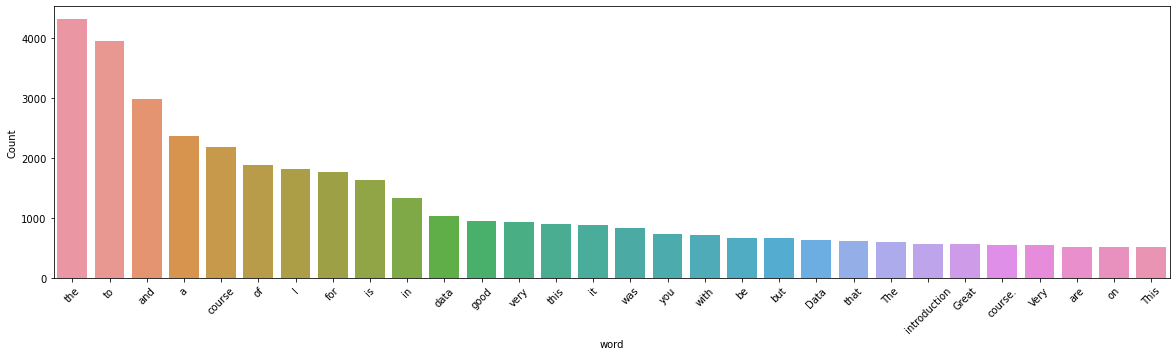

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [13]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    still difficult for me get to used to listen t...
1    very good course, i think there could be a lit...
2    instructions are clear, pace is good and thank...
3    this course was amazing, mostly teaches how to...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [14]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    still difficult for me get to used to listen t...
1    very good course i think there could be a litt...
2    instructions are clear pace is good and thanks...
3    this course was amazing mostly teaches how to ...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [15]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'well', 'could', 'would'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0        still difficult get used listen computer talk
1                    course think little r programming
2      instructions clear pace thanks knowledge learnt
3    course amazing mostly teaches manage work data...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [16]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed
36,2021-02-18,good,4,completer,4,pos,0.4404,pos,
52,2021-02-08,Good,4,completer,4,pos,0.4404,pos,
63,2021-02-01,Nice,5,completer,4,pos,0.4215,pos,
82,2021-01-24,great!!!,5,completer,8,pos,0.7163,pos,
95,2021-01-15,nice,5,completer,4,pos,0.4215,pos,
...,...,...,...,...,...,...,...,...,...
5778,2016-03-08,Great!!!!,5,completer,9,pos,0.0000,neu,
5803,2016-03-03,good,4,dropout,4,pos,0.4404,pos,
5832,2016-02-25,Nice,5,dropout,5,pos,0.4215,pos,
5836,2016-02-23,Very good!!,5,dropout,11,pos,0.5827,pos,


In [17]:
df = df[(df['preprocessed']!= "")]

In [18]:
# Reset the index

df = df.reset_index(drop = True)

In [19]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

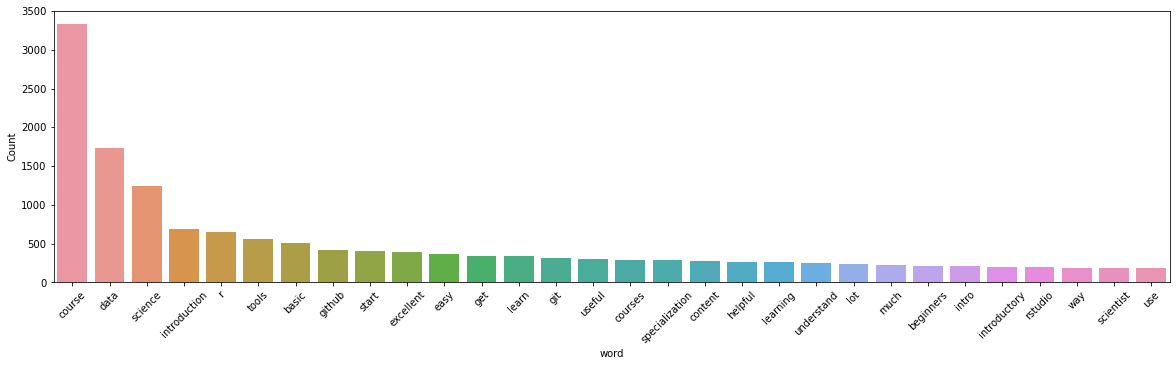

In [20]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [21]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [still, difficult, get, used, listen, computer...
1              [course, think, little, r, programming]
2    [instructions, clear, pace, thanks, knowledge,...
3    [course, amazing, mostly, teaches, manage, wor...
4                          [easy, exploratory, course]
Name: preprocessed, dtype: object

In [22]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(still, RB), (difficult, JJ), (get, VBP), (us...
1    [(course, NN), (think, VBP), (little, JJ), (r,...
2    [(instructions, NNS), (clear, JJ), (pace, NN),...
3    [(course, NN), (amazing, VBG), (mostly, RB), (...
4        [(easy, JJ), (exploratory, JJ), (course, NN)]
Name: preprocessed, dtype: object

In [23]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(still, r), (difficult, a), (get, v), (used, ...
1    [(course, n), (think, v), (little, a), (r, n),...
2    [(instructions, n), (clear, a), (pace, n), (th...
3    [(course, n), (amazing, v), (mostly, r), (teac...
4           [(easy, a), (exploratory, a), (course, n)]
Name: preprocessed, dtype: object

In [25]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [still, difficult, get, use, listen, computer,...
1              [course, think, little, r, programming]
2    [instruction, clear, pace, thanks, knowledge, ...
3    [course, amaze, mostly, teach, manage, work, d...
4                          [easy, exploratory, course]
Name: preprocessed, dtype: object

In [26]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

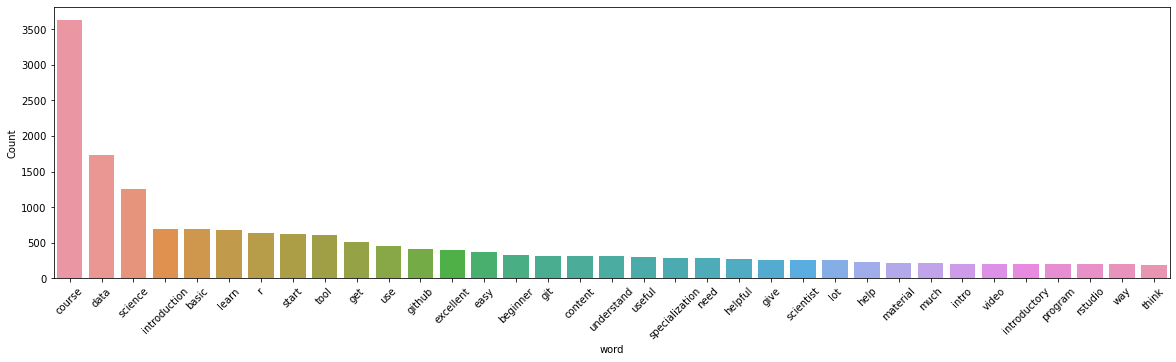

In [27]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [28]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [29]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [30]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [31]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [36]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 3, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.23)

In [37]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: , Topic 1: ')

Topic: 0
Word: 0.094*"course" + 0.074*"data" + 0.054*"science" + 0.035*"introduction" + 0.025*"tool" + 0.025*"start" + 0.021*"basic" + 0.016*"learn" + 0.014*"excellent" + 0.013*"specialization"

Topic: 1
Word: 0.050*"course" + 0.030*"r" + 0.022*"github" + 0.018*"git" + 0.015*"use" + 0.014*"basic" + 0.012*"program" + 0.011*"learn" + 0.011*"easy" + 0.009*"get"

Topic: 2
Word: 0.041*"course" + 0.014*"content" + 0.012*"video" + 0.011*"lecture" + 0.010*"intro" + 0.009*"material" + 0.008*"voice" + 0.008*"time" + 0.007*"little" + 0.007*"one"

Topic 0: 


### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.175427  0.063190       1        1  40.485193
1     -0.009534 -0.137938       2        1  32.646451
2     -0.165894  0.074748       3        1  26.868356, topic_info=             Term         Freq        Total Category  logprob  loglift
19           data  1525.000000  1525.000000  Default  30.0000  30.0000
29        science  1089.000000  1089.000000  Default  29.0000  29.0000
64   introduction   708.000000   708.000000  Default  28.0000  28.0000
10              r   517.000000   517.000000  Default  27.0000  27.0000
25         github   364.000000   364.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
2             get    68.975513   473.088511   Topic3  -5.2666  -0.6113
85          learn    68.679306   561.842157   Topic3  -5.2709  -0.7876
98      excellent    59.374481   337.329192   Topic3  -5.4165  -0.4230
86           need    57.698151   293.700178   Topic3  -5.4452  -0.3131
118           lot    55.252491   219.352535   Topic3  -5.4885  -0.0645

[221 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
388       2  0.812537        4
388       3  0.180564        4
1464      2  0.969292  account
696       2  0.931218   actual
101       2  0.949834  advance
...     ...       ...      ...
35        1  0.239196     work
35        2  0.562112     work
35        3  0.203317     work
66        1  0.970237    world
66        2  0.026582    world

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [39]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.569315174380405

Coherence Score:  0.5312906517376713


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [96]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [97]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

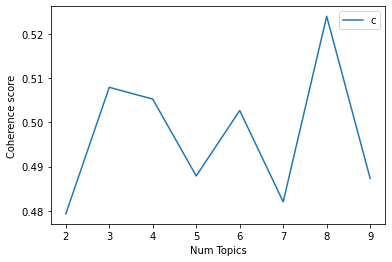

In [98]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [99]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4793
Num Topics = 3  has Coherence Value of 0.5079
Num Topics = 4  has Coherence Value of 0.5053
Num Topics = 5  has Coherence Value of 0.4879
Num Topics = 6  has Coherence Value of 0.5027
Num Topics = 7  has Coherence Value of 0.482
Num Topics = 8  has Coherence Value of 0.524
Num Topics = 9  has Coherence Value of 0.4873


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [90]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [91]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('basic', 0.09639904721871935),
   ('understand', 0.04049320442763066),
   ('helpful', 0.03755079164915231),
   ('give', 0.03713044696651254),
   ('start', 0.028022978842650974),
   ('experience', 0.024800336275746113),
   ('concept', 0.023118957545187054),
   ('knowledge', 0.02213815328569427),
   ('beginner', 0.021017234131988232),
   ('people', 0.017234131988230348)]),
 (1,
  [('data', 0.23333783966472896),
   ('science', 0.16952818710287954),
   ('introduction', 0.09436257942409085),
   ('tool', 0.08151953494659997),
   ('start', 0.056914965526564824),
   ('scientist', 0.03555495471136948),
   ('overview', 0.022441530350141948),
   ('informative', 0.016628362849803974),
   ('field', 0.014735703663647425),
   ('toolbox', 0.012031904826280925)]),
 (2,
  [('excellent', 0.053961456102783724),
   ('easy', 0.052248394004282654),
   ('specialization', 0.04082798001427552),
   ('intro', 0.02955032119914347),
   ('introductory', 0.02926481084939329),
   ('set', 0.026409707351891507)

In [148]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [149]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [150]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,-0.3612,neg,"[still, difficult, get, use, listen, computer,...",still difficult get use listen computer talk,"(3, 0.7543202)",3.0,0.754320
1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,0.4927,pos,"[course, think, could, little, r, programming]",course think could little r programming,"(0, 0.5379512)",0.0,0.537951
2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,0.8126,pos,"[instruction, clear, pace, thanks, knowledge, ...",instruction clear pace thanks knowledge learnt,"(1, 0.8937764)",1.0,0.893776
3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,0.9133,pos,"[course, amaze, mostly, teach, manage, work, d...",course amaze mostly teach manage work data sci...,"(2, 0.97113895)",2.0,0.971139
4,2021-03-07,Easy exploratory course,5,completer,23,pos,0.4404,pos,"[easy, exploratory, course]",easy exploratory course,"(1, 0.8209556)",1.0,0.820956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,2016-01-24,This was a great starter for me. I have very l...,5,dropout,160,pos,0.6249,pos,"[starter, little, experience, data, science, e...",starter little experience data science especia...,"(2, 0.68588006)",2.0,0.685880
5846,2016-01-24,Useful couple of modules for helping you get s...,4,dropout,145,pos,0.6249,pos,"[useful, couple, module, help, get, set, r, gi...",useful couple module help get set r gitgithub ...,"(2, 0.60110307)",2.0,0.601103
5847,2016-01-24,Very common curse about common data things.,3,dropout,43,neu,-0.5829,neg,"[common, curse, common, data, thing]",common curse common data thing,"(0, 0.6644288)",0.0,0.664429
5848,2016-01-24,"It is really basic course, I expected much mor...",1,dropout,130,neg,0.0000,neu,"[basic, course, expect, much, even, offer, 29,...",basic course expect much even offer 29 cheap c...,"(0, 0.9345512)",0.0,0.934551


In [152]:
df_final = df.drop(['joined', 'topic'], axis = 1)

In [153]:
# Save dataframe as a csv file

df_final.to_csv('the-data-toolbox-final.csv')

In [154]:
df_final.head(31)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,topic_id,topic_score
0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,-0.3612,neg,"[still, difficult, get, use, listen, computer,...",3.0,0.754320
1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,0.4927,pos,"[course, think, could, little, r, programming]",0.0,0.537951
2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,0.8126,pos,"[instruction, clear, pace, thanks, knowledge, ...",1.0,0.893776
3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,0.9133,pos,"[course, amaze, mostly, teach, manage, work, d...",2.0,0.971139
4,2021-03-07,Easy exploratory course,5,completer,23,pos,0.4404,pos,"[easy, exploratory, course]",1.0,0.820956
5,2021-03-06,It's very useful for me to get a new skill.,5,completer,43,pos,0.4927,pos,"[useful, get, new, skill]",2.0,0.856217
6,2021-03-05,The course material was in a structured manner...,5,completer,275,pos,0.5413,pos,"[course, material, structure, manner, easy, un...",3.0,0.816413
7,2021-03-05,Well prepared! An essential course for underst...,5,completer,66,pos,0.5093,pos,"[well, prepared, essential, course, understand...",2.0,0.633948
8,2021-03-04,Great beginners course. sets up to R programmi...,5,completer,66,pos,0.7574,pos,"[beginner, course, set, r, program, course, well]",2.0,0.908843
9,2021-03-03,Good overview and introduction to the full world,5,completer,48,pos,0.4404,pos,"[overview, introduction, full, world]",2.0,0.856678
